# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Resources](#resources)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

First, I will analyze the data using probabilities. To get started, I will import the necessary libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Now I will read in the `ab_data.csv` data and take a look at the top few rows. I also want to see the number of rows in the dataset and the number of unique users.

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
len(df)

294478

In [4]:
df['user_id'].nunique()

290584

I am also curious to see the total proportion of users converted, regardless of which group they are in.

In [5]:
df.query('converted == 1')['user_id'].nunique()/df['user_id'].nunique()

0.12104245244060237

I cannot assume that all users in the control group will get the old page and all users in the treatment group will get the new page. Therefore, I want to see how many rows are mismatched in case I need to perform this data wrangling.

In [6]:
len(df.query('group == "control" & landing_page == "new_page" | group == "treatment" & landing_page == "old_page"'))

3893

I will also check if any rows have missing values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


For the rows where `treatment` is not aligned with `new_page` or `control` is not aligned with `old_page`, I cannot be sure if these rows truly received the new or old page. Therefore, I will remove these rows.

In [8]:
# remove rows with mismatched group and landing_page
df2 = df.query('group == "control" & landing_page == "old_page" | group == "treatment" & landing_page == "new_page"')

As a check, the following code should output 0 if the rows were removed.

In [9]:
# check if there are any rows in which group and landing_page are mismatched
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Now I want to see how many unique `user_id` are in `df2` and if there are any duplicates.

In [10]:
df2['user_id'].nunique()

290584

In [11]:
df2['user_id'][df2.duplicated('user_id')]

2893    773192
Name: user_id, dtype: int64

In [12]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


This does not look like a special case that should be duplicated, so I will drop this row.

In [13]:
df2 = df2.drop_duplicates('user_id')

Now that the data wrangling is complete, I want to check again for the overall conversion rate regardless of group. I will also look at the probability of conversion for the `control` and `treatment` group individually.

In [14]:
len(df2.query('converted == 1'))/len(df2)

0.11959708724499628

In [15]:
# conversion rate for control group
len(df2.query('group == "control" & converted == 1'))/len(df2.query('group == "control"'))

0.1203863045004612

In [16]:
# conversion rate for treatment group
len(df2.query('group == "treatment" & converted == 1'))/len(df2.query('group == "treatment"'))

0.11880806551510564

I will also examine the split between `control` and `treatment` by looking at the proportion who received the new page.

In [17]:
len(df2.query('landing_page == "new_page"'))/len(df2)

0.5000619442226688

Based on the results above, there is not sufficient evidence to say that the new treatment page leads to more conversions because the conversion rate for the treatment group is lower than the conversion rate for the control group.

<a id='ab_test'></a>
### Part II - A/B Test

Next, I will analyze the problem using hypothesis testing. If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, my hypotheses should be:

$H_{0}: p_{new} \leq p_{old}, H_{1}: p_{new} > p_{old}$

where $p_{new}$ and $p_{old}$ are the converted rates for the new and old pages, respectively.

I will assume that under $H_{0}$, $p_{new}$ and $p_{old}$ both have true success rates equal to the `converted` success rate regardless of page. I will then use a sample size for each page equal to the ones in `ab_data.csv` and perform the sampling distribution for the difference in `converted` success rate between the two pages over 10,000 iterations of calculating an estimate from $H_{0}$.

First, I will find the convert rates for $p_{new}$ and $p_{old}$ under $H_{0}$.

In [18]:
p_new = len(df2.query('converted == 1'))/len(df2)
p_new

0.11959708724499628

In [19]:
p_old = len(df2.query('converted == 1'))/len(df2)
p_old

0.11959708724499628

I will also need to find $n_{new}$ and $n_{old}$, which are the sample sizes for each page.

In [20]:
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145310

In [21]:
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

Now I will simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under $H_{0}$, and $n_{old}$ transactions with a convert rate of $p_{old}$ under $H_{0}$.

In [22]:
new_page_converted = np.random.binomial(n_new, p_new)/n_new

In [23]:
old_page_converted = np.random.binomial(n_old, p_old)/n_old

Then I can calculate $p_{new}$ - $p_{old}$ to find the difference in the simulated values.

In [24]:
new_page_converted-old_page_converted

-0.0009587967491598293

I will now simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one calculated above.

In [25]:
# simulate 10,000 trials under the null hypothesis
p_diffs = []
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_page_converted-old_page_converted
p_diffs = np.array(p_diffs)

Here is a histogram of `p_diffs`.

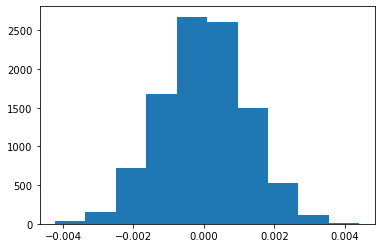

In [26]:
plt.hist(p_diffs);

I will also find the proportion of `p_diffs` that are greater than the actual difference observed in `ab_data.csv`.

In [27]:
p_diffs_obs = len(df2.query('group == "treatment" & converted == 1'))/len(df2.query('group == "treatment"')) - len(df2.query('group == "control" & converted == 1'))/len(df2.query('group == "control"'))
(p_diffs > p_diffs_obs).mean()

0.9021

In scientific studies, this value is called the p-value. The p-value is, assuming that the $H_{0}$ is true, the probability of obtaining a difference that is equal to or more extreme than the observed difference in favor of $H_{1}$. In this case, because $H_{1}$ is $p_{new} > p_{old}$, "more extreme" means any simulated differences that are larger than the observed difference `p_diff_obs`. Because the p-value is higher than the designated Type I error rate of 5%, it means that we fail to reject $H_{0}$.

I will also use `stats.proportions_ztest` to confirm the above results.

In [28]:
# use statsmodels z-test for proportions to find p-value
import statsmodels.api as sm

convert_old = len(df2.query('landing_page == "old_page" & converted == 1'))
convert_new = len(df2.query('landing_page == "new_page" & converted == 1'))
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

In [29]:
sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

(-1.3109241984234394, 0.9050583127590245)

Assuming a normal distribution centered on 0 (meaning that $p_{new} = p_{old}$), the z-score of -1.3109 is the number of standard deviations below the mean for the observed difference `p_diff_obs`. As mentioned previously, the p-value of 0.9051 is the probability of obtaining a difference that is equal to or larger than `p_diff_obs`. Because the p-value is higher than the designated Type I error rate of 5%, we would again fail to reject $H_{0}$. Additionally, the z-score and p-value agree with the findings above.

<a id='regression'></a>
### Part III - A regression approach

Finally, I will use a regression approach to reach the same conclusions as above. Since each row is either a conversion or no conversion, a logistic regression should be used.

I will use **statsmodels** to fit the logistic regression. First I need to add an intercept column, as well as a dummy variable column based on the page a customer receives -- this will be 1 if an individual receives the `treatment` and 0 if `control`.

In [30]:
df2['intercept'] = 1
# create dummy columns based on group - 1 for treatment and 0 for control
# since the only dummy column that matters is the one created for treatment,
# drop the one created for control (where 1 is control and 0 is treatment)
df2[['drop', 'ab_page']] = pd.get_dummies(df2['group'])
df2.drop('drop', axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Now I can use **statsmodels** to import, instantiate, and fit the regression model using the two columns I just created.

In [31]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 06 Sep 2020   Pseudo R-squ.:               8.077e-06
Time:                        21:43:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The p-value associated with `ab_page` is 0.190. This differs from the p-value in **Part II** because in **Part II**, $H_{1}$ was $p_{new} > p_{old}$, so it uses a one-tailed p-value. On the other hand, the logistic regression model uses $H_{0}$ that each coefficient is equal to 0. `np.exp(0)` equals 1, meaning $H_{0}$ is that conversion is 1 times as likely when using the new page compared to the old page, or $p_{new} = p_{old}$. Therefore, $H_{1}$ here is $p_{new} \ne p_{old}$, so it uses a two-tailed p-value. Since the p-value is higher than the threshold of 0.05, we would fail to reject $H_{0}$ and conclude that the new page is not a variable that affects conversion rates.

It is a good idea to consider other factors to add into the regression model because perhaps there are other variables besides `group` that correlate with whether people convert or not. For example, maybe all of the users who convert have some characteristic in common. This would allow the experimenter to further understand the audience and whether there is a difference between the new and old pages.

A disadvantage of adding additional terms into the regression model is that it may sometimes give misleading results, especially in cases of multicollinearity. This is when two or more of the predictor variables are correlated with each other, and it can affect the model's coefficients.

Now along with testing if the conversion rate changes for different pages, I will also add an effect based on which country a user lives in. I will read in `countries.csv` and merge together the dataframes.

In [32]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


I will look at the unique values in `country` to determine how many dummy variables I will need and what to name each column.

In [33]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

Since there are three unique values in `country`, I will create the dummy variable columns and then drop `US` to make the dataframe full rank.

In [34]:
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
# drop one of the dummy columns to make the dataframe full rank
df_new.drop('US', axis=1, inplace=True)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


Now I can create the regression model to look at the impacts of the new vs. old page as well as country.

In [35]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 06 Sep 2020   Pseudo R-squ.:               2.323e-05
Time:                        21:43:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

It does not appear that `country` has an impact on conversion, because compared to the baseline of `US`, the p-values for the `CA` and `UK` coefficients are both higher than the p-value threshold of .05. Additionally, we cannot conclude that there is an effect in choosing between `CA` and `UK` because the 95% confidence intervals for these two coefficients overlap.

I would now like to look at an interaction between page and country to see if there are significant effects on conversion. I will create the necessary additional columns and fit the new model.

In [36]:
df_new['ab_page_CA'] = df_new['ab_page']*df_new['CA']
df_new['ab_page_UK'] = df_new['ab_page']*df_new['UK']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,ab_page_CA,ab_page_UK
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [37]:
log_mod = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'ab_page_CA', 'ab_page_UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 06 Sep 2020   Pseudo R-squ.:               3.482e-05
Time:                        21:43:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
ab_page_CA    -0.0469      0.054     -0.872      0.383      -0.152       0.059
ab_page_UK     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

The country and page interaction does not have a significant effect on conversion because the p-values for all of the coefficients are higher than the p-value threshold of .05. Additionally, the 95% confidence intervals for `CA` and `UK` overlap, and the 95% confidence intervals for `ab_page_CA` and `ab_page_UK` overlap.

<a id='conclusions'></a>
## Conclusions

After an analysis of the data using probability, hypothesis testing, and regression, none of the methods provided sufficient evidence that the new page results in more conversions than the old page. Therefore, the company should keep the old page.

<a id='resources'></a>
## Resources

- [`stats.proportions_ztest` documentation](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html)
- [Interactions](https://knowledge.udacity.com/?nanodegree=nd002&page=1&project=355&query=interaction&rubric=1214&sort=SCORE)